In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## 탐색적 데이터 분석(EDA)

### 결측치 점검

In [2]:
df_raw = pd.read_csv('C:\\Users\\user\\Downloads\\0827_H2_data.csv')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 257 entries, id to hazard_psy3
dtypes: float64(178), int64(77), object(2)
memory usage: 29.3+ MB


In [3]:
# # 클래스 분포 확인
# print(df_raw['burnout60'].value_counts())
# print("번아웃클래스 이진으로 분류한다면: ", df_raw['burnout60'].value_counts().iloc[1:].sum(), "명")

In [4]:
# 결측치 개수가 높은 순위 중 타겟과 관련없는 변수 삭제

df = df_raw.drop(['emp_keep_a', 'hazard_phy_d','hazard_phy_a','hazard_phy_c','hazard_phy_e','hazard_phy_f','hazard_phy_g','hazard_phy_h', 'hazard_phy_i', 'ch_downsizing', 'job_c1_r', 'job_c1', 'emp_pay_type', 'skillmat', 'emp_comp_com_a','emp_comp_com_b','emp_comp_com_c','ch_ic','ch_restruct','wplace_sl','emp_noncon', 'wcomback'], axis = 1)

In [5]:
# 널값 개수와 비율 계산
null_summary = (
    df.isnull().sum()
      .to_frame("널값 개수")
      .assign(널값비율 = lambda x: (x["널값 개수"] / len(df_raw) * 100).round(2))
      .reset_index()
      .rename(columns={'index': '컬럼명'})
)

# 널값 있는 열만 필터링 & 비율 기준 내림차순 정렬
null_summary = (
    null_summary[null_summary["널값 개수"] > 0]
    .sort_values(by="널값비율", ascending=False)
    .reset_index(drop=True)
)

print(null_summary)

                  컬럼명  널값 개수  널값비율
0         comp_size_b    870  5.82
1        wtime_ftwork    584  3.90
2            emp_keep    581  3.88
3          emo_manual    307  2.05
4    wtime_resilience    279  1.87
..                ...    ...   ...
150       wsituation7      2  0.01
151      wsituation13      1  0.01
152            wstat1      1  0.01
153         winten2_a      2  0.01
154     wtime_length3      2  0.01

[155 rows x 3 columns]


In [6]:
# start 파일
# df.to_csv("2PD_v1_0822.csv", encoding="CP949")

### 중복 피쳐 삭제/8,9->결측치 수정

In [7]:
# 불필요한 피쳐 삭제하기 (14개)
df = df.drop(columns=["ptime_r", "stratification", "district", "household", "target", "mode", "hh_num", "eli_num", "hm_01_gender", "hm_01_year", "hm_01_estat", "hm_01_rel_t","wtime_week", "earning1_r"])

print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  panel_survey  ind  ind2  occ  \
0               6     40.0            1  ...             

In [8]:
# 전처리: 8, 9 NULL (5개)
cols = ["hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e"]

df[cols] = df[cols].replace([8, 9], pd.NA)

print(df['hazard_erg_a'].unique())
print(df['hazard_erg_b'].unique())
print(df['hazard_erg_c'].unique())
print(df['hazard_erg_d'].unique())
print(df['hazard_erg_e'].unique())

[6 2 1 7 5 4 3 <NA>]
[1 5 6 3 4 7 2 <NA>]
[ 7.  6.  2.  5.  4.  3.  1. nan]
[ 7.  2.  5.  4.  6.  3. nan  1.]
[ 7.  3.  5.  6.  4.  2.  1. nan]


In [9]:
# 잘못 변경된 변수명 복원
df.rename(columns={
    "wsituation": "wsituation8",
    "wsituation.1": "wsituation9",
    "disc": "disc9",
    "disc.1": "disc8"
}, inplace=True)

### 설문 문항 중 긍부정 변경

In [10]:
# 원래 이름 확인 필요
df['emp_tra_b'].value_counts()

emp_tra_b
2.0    9890
1.0    5053
Name: count, dtype: int64

In [11]:
df['heal_wsick1'].unique()
df['heal_wsick1'].value_counts()

heal_wsick1
2.0    11610
7.0     2630
1.0      675
Name: count, dtype: int64

In [12]:
cols = ["heal_wsick1"]

df[cols] = df[cols].replace(7,2)

print(df['heal_wsick1'].unique())
print(df['heal_wsick1'].value_counts())

[ 2.  1. nan]
heal_wsick1
2.0    14240
1.0      675
Name: count, dtype: int64


In [13]:
cols = [
   "heal_wsick1"
]

# 변환 딕셔너리 
reverse_map = {1: 2, 2: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])


print(df['heal_wsick1'].unique())
print(df['heal_wsick1'].value_counts())

[ 1.  2. nan]
heal_wsick1
1.0    14240
2.0      675
Name: count, dtype: int64


In [14]:
# 2점 척도 변환
cols = [
   "ch_me", 'heal_prob2', 'heal_prob3', 'heal_prob4'
]

# 변환 딕셔너리 
reverse_map = {1: 2, 2: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])


print(df['ch_me'].unique())
print(df['ch_me'].value_counts())

[ 1.  2. nan]
ch_me
1.0    12538
2.0     2273
Name: count, dtype: int64


In [15]:
df["wstat4"].head(10) 

0    2
1    2
2    2
3    3
4    5
5    5
6    5
7    5
8    5
9    5
Name: wstat4, dtype: int64

In [16]:
# 긍/부정 변경
# 5점 척도

cols = [
    "wstat4", "wstat6",
    "wwa1", "wwa2", "wwa3", "wwa4", "wwa5",
    "sleep1", "sleep2", "sleep3",
    "wsituation12", "wsituation14"
]

# 변환 딕셔너리 (5점 척도 역코딩)
reverse_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])

df["wstat4"].head(10) 

0    4
1    4
2    4
3    3
4    1
5    1
6    1
7    1
8    1
9    1
Name: wstat4, dtype: int64

In [17]:
# 3점 척도 
cols_2 = [
   "heal_lim1"
]

# 변환 딕셔너리 (3점 척도 역코딩)
reverse_map = {1: 3, 2: 2, 3: 1}

# 여러 열에 적용
for col in cols_2:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_2].head())
#%%
df["heal_lim1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: heal_lim1, dtype: float64

In [18]:
# 4점 척도
cols_1 = [
    "imte1", "imte2", "imte3", "imte4", "imte5",
]

# 변환 딕셔너리 (4점 척도 역코딩)
reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["imte1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    3.0
1    3.0
2    3.0
3    1.0
4    2.0
5    2.0
6    2.0
7    3.0
8    2.0
9    2.0
Name: imte1, dtype: float64

In [19]:
# 7점 척도
cols_1 = [
    "hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e", 'hazard_psy1', 'hazard_psy2', 'hazard_psy3'
]

# 변환 딕셔너리 (7점 척도 역코딩)
reverse_map = {1: 7, 2: 6, 3: 5, 5: 3, 6: 2, 7: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["hazard_erg_a"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    2.0
1    6.0
2    7.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: hazard_erg_a, dtype: object

### 연속형 변수 재범주화

In [20]:
df['heal_abs1'].value_counts()

heal_abs1
0.0      14127
2.0        181
1.0        127
3.0        113
5.0         80
7.0         65
10.0        31
8.0         25
4.0         24
6.0         10
15.0         9
20.0         6
30.0         6
14.0         5
13.0         5
12.0         4
90.0         3
60.0         2
11.0         1
180.0        1
120.0        1
50.0         1
21.0         1
Name: count, dtype: int64

In [21]:
# 범주화 

df["heal_abs1_group"] = np.where(df["heal_abs1"] == 0, 0, 1)
df['heal_abs1_group'] = df['heal_abs1_group'].map({0: 1, 1: 2})
#%%
print(df["heal_abs1_group"].head())
#%%
df["heal_abs1_group"].value_counts()


0    1
1    1
2    1
3    1
4    1
Name: heal_abs1_group, dtype: int64


heal_abs1_group
1    14127
2      829
Name: count, dtype: int64

In [22]:
# 구간 (0~60, 61~120, 121 이상)
bins = [0, 60, 120, float("inf")]
labels = [1, 2, 3]

df["ctime_group"] = pd.cut(df["ctime"], bins=bins, labels=labels, right=True)
#%%
print(df["ctime_group"].head())
#%%
df["ctime_group"].value_counts()
#%%

0      1
1      1
2      1
3      2
4    NaN
Name: ctime_group, dtype: category
Categories (3, int64): [1 < 2 < 3]


ctime_group
1    12582
2     1150
3      328
Name: count, dtype: int64

In [23]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['heal_abs1','ctime'], axis = 1)
print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  ind2  occ  occ2  comp_sizea_r  \
0               6     40.0            1  ...    46    3 

### 중복 피쳐 삭제

In [24]:
# 1차 프로젝트에서 파생변수 만들었던 변수 삭제
df = df.drop(['occ', 'occ2', 'age', 'earning2_r', 'wday_week', 'woutside4', 'wtime_r', 'wduration_y'], axis = 1)

## Feature Selection

### 상관관계 매트릭스 분석

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
# sns.heatmap(corr, cmap="coolwarm", center=0)
# plt.show()

In [26]:
# 상관계수 절댓값이 0.8 이상인 쌍만 추출 (자기 자신 제외)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
        .stack()                                               
        .reset_index()
        .rename(columns={'level_0': '변수1', 'level_1': '변수2', 0: '상관계수'})
)

# 조건 필터링
high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

print(high_corr.sort_values(by='상관계수', ascending=False).head(20))

                    변수1           변수2      상관계수
10231       comp_size_b  comp_sizeb_r  1.000000
10230       comp_size_b  comp_sizea_r  1.000000
15861             disc3         disc4  0.988628
21086               ind          ind2  0.985571
15758             disc2         disc3  0.984493
15759             disc2         disc4  0.982562
1804     compsize_group  comp_sizeb_r  0.975227
1660     compsize_group   comp_size_b  0.969841
15654             disc8         disc2  0.962101
15656             disc8         disc4  0.956305
15655             disc8         disc3  0.954483
15549             disc7         disc8  0.944109
15550             disc7         disc2  0.920967
21099      comp_sizea_r  comp_sizeb_r  0.920086
2195   compsize_group_a  comp_sizeb_r  0.916659
15552             disc7         disc4  0.913893
15551             disc7         disc3  0.913422
1803     compsize_group  comp_sizea_r  0.910546
2051   compsize_group_a   comp_size_b  0.893071
15443             disc6         disc7  0

In [27]:
unique_vars = set(high_corr['변수1']).union(set(high_corr['변수2']))
print("조건 충족하는 변수 개수:", len(unique_vars))
print("변수 목록:", unique_vars)

조건 충족하는 변수 개수: 23
변수 목록: {'comp_sizea_r', 'comp_size_b', 'winten2_a', 'disc7', 'woutside_group', 'earning1', 'woutside4_a', 'disc3', 'disc4', 'compsize_group_a', 'decla_a', 'disc2', 'decla_b', 'winten3_c', 'disc6', 'compsize_group', 'ind2', 'disc8', 'comp_sizeb_r', 'earning2_group_b', 'winten3_d', 'winten2_b', 'ind'}


In [28]:
# 상관분석 결과 필요없는 변수 삭제
df = df.drop(['comp_size_b', 'comp_sizea_r', 'comp_sizeb_r', 'ind', 'ind2', 'earning1', 'woutside4_a'], axis = 1)

In [29]:
# disc 변수 : 차별 유/무로 파생변수 생성
cols = ['disc1','disc2','disc3','disc4','disc5',
        'disc6','disc7','disc8','disc9','disc10','disc11']

# 하나라도 1이 있으면 1, 아니면 0
df['disc_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['disc_group'] = df['disc_group'].map({0: 1, 1: 2})

print(df['disc_group'].unique())

[2 1]


In [30]:
# decla 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['decla_a','decla_b']

# 하나라도 1이 있으면 1, 아니면 0
df['decla_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['decla_group'] = df['decla_group'].map({0: 1, 1: 2})

print(df['decla_group'].unique())

[2 1]


In [31]:
# winten2 변수 : 작업 강도가 세다로 파생변수 생성(7점 척도)
cols = ['winten2_a','winten2_b']

# 둘 중 하나라도 있으면 최대값
df['winten2_group'] = df[cols].max(axis=1, skipna=True)

print(df['winten2_group'].unique())

[ 5.  6.  7.  1.  4.  3.  2. nan]


In [32]:
# winten3 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e']

# 하나라도 1이 있으면 1, 아니면 0
df['winten3_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['winten3_group'] = df['winten3_group'].map({0: 1, 1: 2})

print(df['winten3_group'].unique())

[2 1]


In [33]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['disc1','disc2','disc3','disc4','disc5',
              'disc6','disc7','disc8','disc9','disc10','disc11','decla_a','decla_b','winten2_a','winten2_b', 'winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e'], axis = 1)

### 조작적 정의에 사용된 변수 삭제

In [34]:
df = df.drop(['weng1','weng2','weng3','wsituation14','wwa2','sleep2','sleep3','weng4','weng5','wsituation1','wstat4','wsituation2','wsituation12', 'wsituation10','wsituation9', 'emp_manaqual_a'], axis = 1)

### 모델의 피처 중요도 기반 삭제 

In [35]:
df = df.drop(['sleep1', 'emp_tra_b', 'ch_me', 'emp_winflu_a', 'emp_winflu_b'], axis = 1)

# 'heal_prob1', 'heal_prob2', 'heal_prob3', 'heal_prob4', 'heal_prob5', 'heal_prob6', 'heal_prob8'

### 인구 통계 변수 빼고 저장

In [36]:
df_new = df.drop(['id', 'area', 'gender', 'age_group', 'emp_period_group', 'wtime_group', 'marital', 'children', 'panel_survey', 'edu', 'occ_group_a', 'occ_t2_group_a'], axis = 1)

### 널값 삭제

In [37]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 157 entries, burnout60 to winten3_group
dtypes: category(1), float64(129), int64(24), object(3)
memory usage: 17.8+ MB


In [38]:
df_new = df_new.dropna()

In [39]:
df_new

,burnout60,wtime_length5,compsize_group,woutside_group,compsize_group_a,wday_week_group_a,woutside4_group_a,earning2_group_b,emp_stat,emp_con_term,...,income_bal,hazard_psy1,hazard_psy2,hazard_psy3,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,lv1,2,4,0,1,2,2,5,1,2.0,...,4.0,3.0,4.0,3.0,1,1,2,2,5.0,2
1,lv2,2,11,0,3,2,2,4,1,2.0,...,3.0,4.0,4.0,4.0,1,1,2,2,6.0,2
2,lv1,2,1,0,1,3,2,4,1,2.0,...,3.0,6.0,6.0,6.0,1,1,2,2,5.0,2
3,lv1,2,10,0,3,2,1,4,1,2.0,...,1.0,1.0,1.0,1.0,1,2,2,2,7.0,2
5,lv1,2,10,0,3,2,3,4,1,1.0,...,1.0,1.0,1.0,1.0,1,1,2,2,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,lv1,1,12,1,3,2,3,5,1,2.0,...,3.0,1.0,1.0,2.0,1,1,2,2,4.0,2
14952,lv2,2,4,0,1,2,3,3,1,2.0,...,4.0,4.0,3.0,4.0,1,1,2,2,4.0,2
14953,lv1,2,4,0,1,2,3,4,1,2.0,...,3.0,4.0,3.0,3.0,1,1,2,2,5.0,2
14954,lv1,2,4,0,1,2,3,5,1,2.0,...,3.0,5.0,3.0,5.0,1,1,2,2,5.0,2


### 변수 타입 변경

In [40]:
print(df_new.select_dtypes(include=['object']).columns.tolist())
print(df_new.select_dtypes(include=['category']).columns.tolist())

['burnout60', 'hazard_erg_a', 'hazard_erg_b']
['ctime_group']


In [41]:
print(df_new.select_dtypes(include=['float64']).columns.tolist())

['emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_c', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_female', 'comp_sjob', 'ch_tech', 'ch_ps', 'imte1', 'imte2', 'imte3', 'imte4', 'imte5', 'safeinform', 'wsituation3', 'wsituation4', 'wsituation5', 'wsituation11', 'wsituation6', 'wsituation7', 'wsituation13', 'wstat1', 'wstat2', 'wstat5', 'wstat6', 'wstat7', 'emo_manual', 'asb5', 'asb6', 'asb7', 'wtime_con1', 'wtime_night_a', 'wtime_sun_a', 'wtime_sat_a', 'wtime_long_a', 'wtime_resilience', 'wtime_arr_a', 'wtime_ftwork', 'wtime_private', 'hazard_phy_b', 

In [42]:
num_cols = df.select_dtypes(include=['float64']).columns

for col in num_cols:
    min_val, max_val = df[col].min(), df[col].max()
    print(f"{col}: 범위=({min_val}, {max_val})")

emp_con_term: 범위=(1.0, 2.0)
emp_keep: 범위=(1.0, 2.0)
emp_own_mgmt: 범위=(1.0, 2.0)
emp_fptime: 범위=(1.0, 2.0)
emp_wage: 범위=(1.0, 3.0)
emp_stat_sp: 범위=(1.0, 2.0)
income_pos_a: 범위=(1.0, 2.0)
income_pos_b: 범위=(1.0, 2.0)
income_pos_c: 범위=(1.0, 2.0)
income_pos_d: 범위=(1.0, 2.0)
income_pos_e: 범위=(1.0, 2.0)
income_pos_f: 범위=(1.0, 2.0)
income_pos_g: 범위=(1.0, 2.0)
income_pos_h: 범위=(1.0, 2.0)
income_pos_i: 범위=(1.0, 2.0)
income_pos_j: 범위=(1.0, 2.0)
emp_place: 범위=(1.0, 2.0)
emp_suggest_a: 범위=(1.0, 2.0)
emp_suggest_b: 범위=(1.0, 2.0)
emp_manaqual_b: 범위=(1.0, 5.0)
emp_manaqual_c: 범위=(1.0, 5.0)
emp_manaqual_d: 범위=(1.0, 5.0)
emp_manaqual_e: 범위=(1.0, 5.0)
emp_comp_ass_a: 범위=(1.0, 5.0)
emp_comp_ass_b: 범위=(1.0, 5.0)
emp_comp_ass_c: 범위=(1.0, 5.0)
emp_comp_ass_d: 범위=(1.0, 5.0)
emp_comp_ass_e: 범위=(1.0, 5.0)
emp_comp_ass_f: 범위=(1.0, 5.0)
emp_rep: 범위=(1.0, 3.0)
emp_winflu_c: 범위=(1.0, 7.0)
emp_tra_c: 범위=(1.0, 2.0)
emp_tra_d: 범위=(1.0, 2.0)
wsector: 범위=(1.0, 4.0)
comp_female: 범위=(1.0, 3.0)
comp_sjob: 범위=(1.0, 4.0)
ch_t

In [43]:
# 데이터 타입 변경
df_new['hazard_erg_a'] = df_new['hazard_erg_a'].astype('int64')
df_new['hazard_erg_b'] = df_new['hazard_erg_b'].astype('int64')
df_new['ctime_group'] = df_new['ctime_group'].astype('int64')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11344 entries, 0 to 14955
Columns: 157 entries, burnout60 to winten3_group
dtypes: float64(129), int64(27), object(1)
memory usage: 13.7+ MB


In [44]:
# 타겟 클래스번호 전처리
df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
df_new['burnout60'] = df_new['burnout60'].replace("lv3", 3)
df_new['burnout60'].unique()

array([1, 2, 3], dtype=int64)

In [45]:
df_new['burnout60'] = df_new['burnout60'].astype('int64')

In [46]:
df_new['burnout60'] = df_new['burnout60'] - 1

In [47]:
df_new['burnout60'].unique()

array([0, 1, 2], dtype=int64)

In [48]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11344 entries, 0 to 14955
Columns: 157 entries, burnout60 to winten3_group
dtypes: float64(129), int64(28)
memory usage: 13.7 MB


## 모델 적용

### 1차 모델 - multiclass(LGBM)

In [48]:
# 클래스 분포 확인
print(df_new['burnout60'].value_counts())
print("번아웃클래스 이진으로 분류한다면: ", df_new['burnout60'].value_counts().iloc[1:].sum(), "명")

burnout60
0    9704
1    1424
2     216
Name: count, dtype: int64
번아웃클래스 이진으로 분류한다면:  1640 명


In [49]:
# 학습(훈련) 데이터
train_X = df_new.drop(['burnout60'], axis = 1)
train_Y = df_new["burnout60"]

print("train_X 데이터: ", train_X.shape)
print("train_Y 데이터: ", train_Y.shape)

train_X 데이터:  (11344, 156)
train_Y 데이터:  (11344,)


In [51]:
from sklearn.model_selection import train_test_split

# 1차 분할: Train (80%) vs Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42, stratify=train_Y
)

# 2차 분할: Train 내부에서 다시 Train (80%) vs Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7260, 156) (7260,)
Validation shape: (1815, 156) (1815,)
Test shape: (2269, 156) (2269,)


In [52]:
print("Train 클래스 분포:")
print(y_train.value_counts())               
print(y_train.value_counts(normalize=True))  

Train 클래스 분포:
burnout60
0    6210
1     911
2     139
Name: count, dtype: int64
burnout60
0    0.855372
1    0.125482
2    0.019146
Name: proportion, dtype: float64


In [53]:
print("val 클래스 분포:")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True))

val 클래스 분포:
burnout60
0    1553
1     228
2      34
Name: count, dtype: int64
burnout60
0    0.855647
1    0.125620
2    0.018733
Name: proportion, dtype: float64


In [54]:
print("Test 클래스 분포:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Test 클래스 분포:
burnout60
0    1941
1     285
2      43
Name: count, dtype: int64
burnout60
0    0.855443
1    0.125606
2    0.018951
Name: proportion, dtype: float64


In [55]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [56]:
# SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_train_scaled, y_train)
print("After SMOTE-ENN:", pd.Series(y_train_res).value_counts())

c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


After SMOTE-ENN: burnout60
2    6210
1    6164
0    2710
Name: count, dtype: int64


In [57]:
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import optuna

def objective(trial):
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'boosting_type': 'gbdt',
        "class_weight": "balanced",
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_float('lgbm_reg_alpha', 1e-8, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('lgbm_reg_lambda', 1e-8, 1e-1, log=True),
        # "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        # "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbosity': -1
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_scaled, y_val)],
        callbacks=[early_stopping(50), log_evaluation(0)]
    )

    y_pred = model.predict(X_val_scaled)
    f1_class2 = f1_score(y_val, y_pred, average=None, labels=[0,1,2])[2]
    return f1_class2

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_trial.params
print("Best Params:", best_params)

[I 2025-09-02 16:48:45,427] A new study created in memory with name: no-name-deec3059-51b2-4347-bace-8c33954725f8


Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.403661
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.540573
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.522216
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.432731
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.450896
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.540243
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[88]	valid_0's multi_logloss: 0.392627
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[90]	valid_0's multi_logloss: 0.439383
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.470085
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[82]	valid_0's multi_logloss: 0.415837
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.372428
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[76]	valid_0's multi_logloss: 0.38429
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.447038
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[74]	valid_0's multi_logloss: 0.433819
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.403123
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.530643
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.384612
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[72]	valid_0's multi_logloss: 0.38075
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.405093
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.472258
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.555419
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.433576
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.471245
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.582926
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.385403
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.398145
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.531592
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.436505
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.40866
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.432691
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.412774
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.41481
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.429203
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.57098
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.449863
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.456543
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.389403
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.587503
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.406982
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.39057
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.51324
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.450756
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.442468
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.530562
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.451869
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.470963
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[85]	valid_0's multi_logloss: 0.407054
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.458539
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[66]	valid_0's multi_logloss: 0.394002
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.411299
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.524281
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.452349
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.421586
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.439776
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.424003
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.401868
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.405661
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.420171
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.397356
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.394631
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.3933
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.419324
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.424959
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.458199
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.468912
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.464078
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.483403
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.480874
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.466039
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.502225
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.502624
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.458366
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.492657
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.431746
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.546736
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.545044
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.565243
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.581001
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.560532
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.543335
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.555791
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.523116
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.530683
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.522587
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.526143
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.522499
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.617479
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.513421
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.490208
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.532721
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.570964
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.586864
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.547029
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.550262
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.561645
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.575883
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.585839
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.548242
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.515649
Training until validation scores don't improve for 50 rounds


C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_16364\1415051308.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.527913
Best Params: {'num_leaves': 19, 'learning_rate': 0.02053400784919012, 'feature_fraction': 0.15537130463227172, 'bagging_fraction': 0.199489881579102, 'bagging_freq': 10, 'lgbm_reg_alpha': 6.011447761770446e-07, 'lgbm_reg_lambda': 3.541359421390768e-06}


#### 모델 적용(multiclass)(LGBM)

In [58]:
best_model = LGBMClassifier(
    **best_params,
    objective="multiclass",
    num_class=3,
    random_state=42
)
best_model.fit(X_train_res, y_train_res)

LGBMClassifier(bagging_fraction=0.199489881579102, bagging_freq=10,
               feature_fraction=0.15537130463227172,
               learning_rate=0.02053400784919012,
               lgbm_reg_alpha=6.011447761770446e-07,
               lgbm_reg_lambda=3.541359421390768e-06, num_class=3,
               num_leaves=19, objective='multiclass', random_state=42)

In [59]:
from sklearn.metrics import precision_recall_curve

y_proba_val = best_model.predict_proba(X_val_scaled)
y_true_bin = (y_val == 2).astype(int)  # 클래스 2 vs 나머지

prec, rec, thresh = precision_recall_curve(y_true_bin, y_proba_val[:, 2])
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print("Best Threshold for class 2:", best_thresh)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F1:", f1_scores[best_idx])

Best Threshold for class 2: 0.41582954701779734
Precision: 0.5 Recall: 0.5 F1: 0.4999999950000001


In [60]:
y_pred_val = []
for p in y_proba_val:
    if p[2] > best_thresh:     # 클래스 2 기준 threshold 적용
        y_pred_val.append(2)
    else:
        y_pred_val.append(np.argmax(p[:2]))  # 클래스 0/1 중 높은 확률 선택
y_pred_val = np.array(y_pred_val)

print("\n=== Validation Report with threshold tuning ===")
print(classification_report(y_val, y_pred_val))


=== Validation Report with threshold tuning ===
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1553
           1       0.30      0.66      0.41       228
           2       0.48      0.47      0.48        34

    accuracy                           0.76      1815
   macro avg       0.58      0.64      0.58      1815
weighted avg       0.86      0.76      0.79      1815



#### feature importance 시각화

In [61]:
# feature importance (gain 기준)
importance = pd.DataFrame(best_model.booster_.feature_importance(importance_type='gain'), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending = True).tail(20)
importance

# 변수중요도 비율로 전환
importance['importance_pct'] = importance['importance'] / importance['importance'].sum() * 100
importance.head(20)

,importance,importance_pct
who4,1223.191018,1.702304
wstat3,1496.271307,2.082348
emp_comp_ass_f,1565.122603,2.178167
wwa3,1679.958092,2.337983
wstat1,1924.293401,2.678022
who5,1975.439314,2.749202
emp_comp_ass_b,2174.557119,3.026312
who3,2437.867610,3.392759
wsituation6,2514.898090,3.499962
wsituation13,3070.540518,4.273244


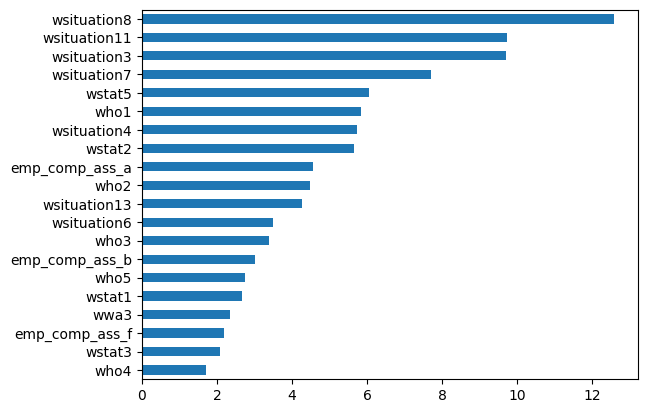

In [62]:
importance['importance_pct'].plot.barh()
plt.show()

#### Shap 클래스2(번아웃 진단군) 변수 중요도 확인

In [63]:
# LightGBM 모델 학습된 객체: best_model
explainer = shap.TreeExplainer(best_model)

In [64]:
# SHAP 값 (Explanation 객체)
shap_values = explainer(X_train_res)
shap_values_class2 = shap_values[:,:,2]

# SHAP 절댓값 평균으로 변수 중요도 계산
shap_importance = np.abs(shap_values_class2.values).mean(axis=0)

fi_shap = pd.DataFrame({
    'feature': X_train.columns,
    'importance_shap': shap_importance
}).sort_values(by='importance_shap', ascending=False).reset_index(drop=True)

print(fi_shap.head(20))

           feature  importance_shap
0      wsituation8         0.101762
1     wsituation11         0.099218
2      wsituation3         0.092431
3      wsituation7         0.091700
4      wsituation4         0.086264
5             who2         0.068376
6      wsituation6         0.064236
7             who1         0.063031
8     wsituation13         0.051615
9             who3         0.048155
10  emp_comp_ass_b         0.045154
11            wwa3         0.040873
12          wstat2         0.038694
13          wstat1         0.034930
14      safeinform         0.032594
15            who5         0.031240
16           imte3         0.027453
17          wstat5         0.026176
18          wstat7         0.024130
19            who4         0.022742


In [65]:
# 변수 이름 저장
top_features = fi_shap['feature'].head(50).tolist()

X_top = X_train[top_features]
X_top

,wsituation8,wsituation11,wsituation3,wsituation7,wsituation4,who2,wsituation6,who1,wsituation13,who3,...,wsituation5,imte2,hazard_erg_d,hazard_psy2,heal_prob2,emp_manaqual_b,emp_con_term,emp_boss_gender,heal_prob1,emp_manaqual_e
9765,2,2.0,1.0,1.0,2.0,3,2.0,3.0,2.0,4,...,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1,2.0,2.0
4450,2,3.0,3.0,3.0,3.0,5,3.0,5.0,4.0,5,...,3.0,4.0,3.0,2.0,1.0,2.0,2.0,1,2.0,2.0
14306,2,2.0,1.0,1.0,2.0,2,2.0,3.0,2.0,2,...,4.0,2.0,4.0,2.0,1.0,2.0,2.0,1,2.0,2.0
5979,3,4.0,3.0,2.0,2.0,2,3.0,3.0,3.0,3,...,3.0,4.0,3.0,5.0,2.0,2.0,2.0,2,1.0,2.0
622,2,3.0,2.0,2.0,2.0,2,3.0,2.0,3.0,2,...,2.0,3.0,5.0,1.0,2.0,1.0,2.0,2,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,3,3.0,3.0,2.0,2.0,2,2.0,1.0,3.0,1,...,3.0,3.0,2.0,2.0,1.0,2.0,2.0,1,2.0,2.0
4703,3,3.0,2.0,2.0,3.0,3,3.0,2.0,2.0,2,...,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1,2.0,3.0
11564,3,2.0,3.0,3.0,3.0,1,4.0,2.0,4.0,2,...,3.0,2.0,1.0,3.0,1.0,1.0,2.0,1,2.0,2.0
11174,3,3.0,2.0,3.0,2.0,2,2.0,2.0,4.0,2,...,2.0,3.0,3.0,2.0,1.0,2.0,2.0,1,2.0,3.0


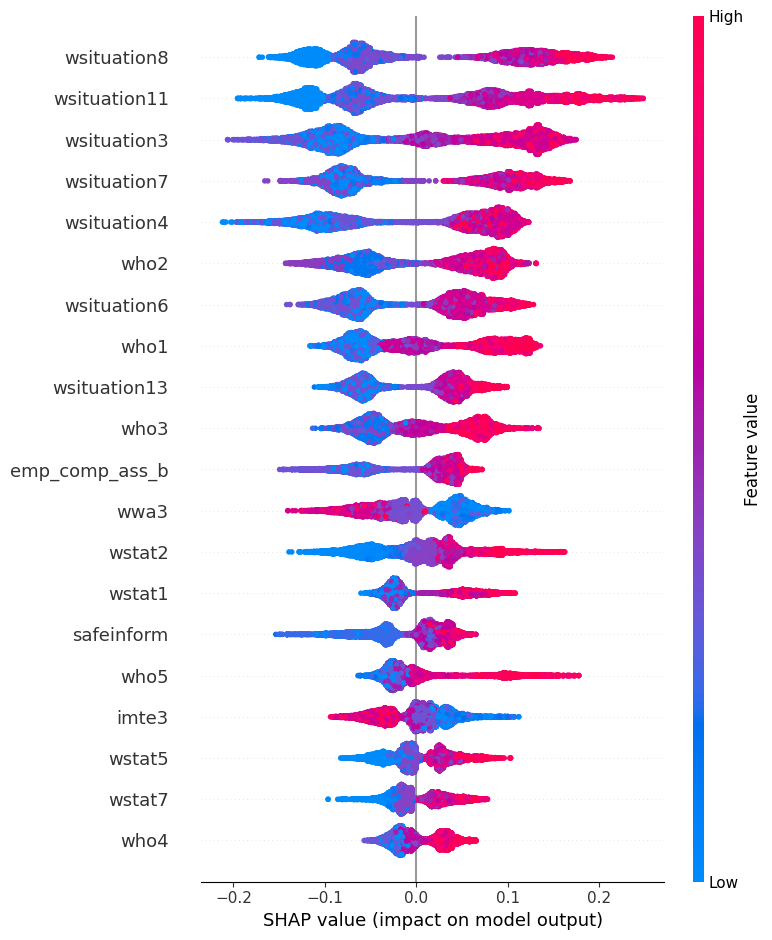

In [66]:
# summary plot
shap.summary_plot(
    shap_values_class2,
    X_train_res,
    feature_names=X_train.columns  
)

### 2차 모델 - 변수 선택 50개(클래스2 중요도 기반)

In [67]:
X_train_top = X_train[top_features]
X_val_top   = X_val[top_features]
X_test_top  = X_test[top_features]

print("Train shape:", X_train_top.shape)
print("Train shape:", X_val_top.shape)

Train shape: (7260, 50)
Train shape: (1815, 50)


In [68]:
scaler = MinMaxScaler()
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_val_top_scaled   = scaler.transform(X_val_top)
X_test_top_scaled  = scaler.transform(X_test_top)

In [69]:
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)
X_train_res, y_train_res = smote_enn.fit_resample(X_train_top_scaled, y_train)

print("Resampled class distribution:\n", pd.Series(y_train_res).value_counts())

Resampled class distribution:
 burnout60
2    6210
1    6163
0    3781
Name: count, dtype: int64


In [70]:
model_top = LGBMClassifier(
    **best_params,        # Optuna에서 찾은 최적 파라미터 쓰는 게 좋음
    objective="multiclass",
    num_class=3,
    random_state=42
)

model_top.fit(
    X_train_res, y_train_res,
    eval_set=[(X_val_top_scaled, y_val)],
    callbacks=[early_stopping(50), log_evaluation(1)]
)

[1]	valid_0's multi_logloss: 1.35563
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.3302
[3]	valid_0's multi_logloss: 1.30411
[4]	valid_0's multi_logloss: 1.28088
[5]	valid_0's multi_logloss: 1.258
[6]	valid_0's multi_logloss: 1.23621
[7]	valid_0's multi_logloss: 1.21581
[8]	valid_0's multi_logloss: 1.19425
[9]	valid_0's multi_logloss: 1.17482
[10]	valid_0's multi_logloss: 1.15677
[11]	valid_0's multi_logloss: 1.13744
[12]	valid_0's multi_logloss: 1.11964
[13]	valid_0's multi_logloss: 1.10366
[14]	valid_0's multi_logloss: 1.08658
[15]	valid_0's multi_logloss: 1.06927
[16]	valid_0's multi_logloss: 1.05468
[17]	valid_0's multi_logloss: 1.04022
[18]	valid_0's multi_logloss: 1.02561
[19]	valid_0's multi_logloss: 1.01201
[20]	valid_0's multi_logloss: 0.999037
[21]	valid_0's multi_logloss: 0.985953
[22]	valid_0's multi_logloss: 0.973272
[23]	valid_0's multi_logloss: 0.961167
[24]	valid_0's multi_logloss: 0.949108
[25]	valid_0's multi_logloss: 0.93

LGBMClassifier(bagging_fraction=0.199489881579102, bagging_freq=10,
               feature_fraction=0.15537130463227172,
               learning_rate=0.02053400784919012,
               lgbm_reg_alpha=6.011447761770446e-07,
               lgbm_reg_lambda=3.541359421390768e-06, num_class=3,
               num_leaves=19, objective='multiclass', random_state=42)

In [71]:
y_proba_val = model_top.predict_proba(X_val_top_scaled)
y_true_bin = (y_val == 2).astype(int)

prec, rec, thresh = precision_recall_curve(y_true_bin, y_proba_val[:, 2])
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print("Best Threshold for class 2:", best_thresh)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F1:", f1_scores[best_idx])

Best Threshold for class 2: 0.4117028388953168
Precision: 0.4418604651162791 Recall: 0.5588235294117647 F1: 0.4935064885748019


In [72]:
y_pred_val = []
for p in y_proba_val:
    if p[2] > best_thresh:     # 클래스 2 기준 threshold 적용
        y_pred_val.append(2)
    else:
        y_pred_val.append(np.argmax(p[:2]))  # 클래스 0/1 중 높은 확률 선택
y_pred_val = np.array(y_pred_val)

print("\n=== Validation Report with threshold tuning ===")
print(classification_report(y_val, y_pred_val))


=== Validation Report with threshold tuning ===
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1553
           1       0.31      0.45      0.37       228
           2       0.43      0.53      0.47        34

    accuracy                           0.80      1815
   macro avg       0.55      0.61      0.58      1815
weighted avg       0.84      0.80      0.81      1815



### 3차 모델 - 이진분류

In [49]:
# 1, 2 클래스 결합
df_new['burnout60'] = df_new['burnout60'].replace(2, 1)

print(df_new['burnout60'].value_counts())
print("번아웃클래스 이진 분류: ", df_new['burnout60'].value_counts().iloc[1:].sum(), "명")

burnout60
0    9704
1    1640
Name: count, dtype: int64
번아웃클래스 이진 분류:  1640 명


In [50]:
# 학습(훈련) 데이터
train_X = df_new.drop(['burnout60'], axis = 1)
train_Y = df_new["burnout60"]

print("train_X 데이터: ", train_X.shape)
print("train_Y 데이터: ", train_Y.shape)

train_X 데이터:  (11344, 156)
train_Y 데이터:  (11344,)


In [51]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (80%) vs Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42, stratify=train_Y
)

# 2차 분할: Train 내부에서 다시 Train (80%) vs Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7260, 156) (7260,)
Validation shape: (1815, 156) (1815,)
Test shape: (2269, 156) (2269,)


In [52]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [53]:
# SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_train_scaled, y_train)
print("After SMOTE-ENN:", pd.Series(y_train_res).value_counts())

c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


After SMOTE-ENN: burnout60
1    6152
0    2824
Name: count, dtype: int64


In [54]:
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
import optuna

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "class_weight": "balanced",
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 2e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 255, step=8),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 60, step=5),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        "random_state": 42,
        "verbosity": -1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for tr_idx, val_idx in skf.split(X_train_res, y_train_res):
        X_tr, X_val_fold = X_train_res[tr_idx], X_train_res[val_idx]
        y_tr, y_val_fold = y_train_res[tr_idx], y_train_res[val_idx]

        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_pred)
        f1_scores.append(f1)

    return np.mean(f1_scores)

# --------------------------
# 3. Optuna 실행
# --------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_trial.params
print("Best Params:", best_params)

[I 2025-09-03 10:08:06,307] A new study created in memory with name: no-name-ba3e5efd-8081-466f-b66c-7a0978b758f5
[I 2025-09-03 10:08:07,573] Trial 0 finished with value: 0.9560279961050361 and parameters: {'n_estimators': 600, 'learning_rate': 0.02106787361027207, 'num_leaves': 103, 'max_depth': 2, 'min_child_samples': 40, 'subsample': 0.8091397959416423, 'colsample_bytree': 0.9428144970867092, 'reg_alpha': 2.739567338725627e-08, 'reg_lambda': 0.0005247771316412359}. Best is trial 0 with value: 0.9560279961050361.
[I 2025-09-03 10:08:11,944] Trial 1 finished with value: 0.9455873146384883 and parameters: {'n_estimators': 300, 'learning_rate': 0.0025388240509665793, 'num_leaves': 87, 'max_depth': 16, 'min_child_samples': 60, 'subsample': 0.8653522212282992, 'colsample_bytree': 0.8713734206713117, 'reg_alpha': 2.1435133173994114e-06, 'reg_lambda': 0.010418908564998941}. Best is trial 0 with value: 0.9560279961050361.
[I 2025-09-03 10:08:13,156] Trial 2 finished with value: 0.92768289521

Best Params: {'n_estimators': 800, 'learning_rate': 0.09067346396993788, 'num_leaves': 31, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.8886344938878071, 'colsample_bytree': 0.7532247465755111, 'reg_alpha': 7.951659643373352e-06, 'reg_lambda': 1.6198070925817377e-08}


#### 모델 적용 

In [55]:
best_model = LGBMClassifier(**best_params, objective="binary", class_weight="balanced", random_state=42)

best_model.fit(X_train_res, y_train_res)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7532247465755111,
               learning_rate=0.09067346396993788, max_depth=16,
               min_child_samples=30, n_estimators=800, objective='binary',
               random_state=42, reg_alpha=7.951659643373352e-06,
               reg_lambda=1.6198070925817377e-08, subsample=0.8886344938878071)

In [56]:
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix

pos_prob_val = best_model.predict_proba(X_val_scaled)[:, 1]

# 목표 재현율을 만족하는 임계값 탐색
target_recall = 0.80
ths = np.linspace(0.0, 1.0, 1001)   # 0~1 사이 0.001 간격
best_t, best_precision = 0.5, -1

for t in ths:
    pred = (pos_prob_val >= t).astype(int)
    r = recall_score(y_val, pred)
    if r >= target_recall:
        p = precision_score(y_val, pred)
        if p > best_precision:
            best_precision, best_t = p, t

print(f"\n[Validation] chosen threshold = {best_t:.3f} "
      f"(precision={best_precision:.3f}, target recall ≥ {target_recall})")

y_val_pred = (pos_prob_val >= best_t).astype(int)

# 결과 확인
print(classification_report(y_val, y_val_pred, digits=2))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


[Validation] chosen threshold = 0.058 (precision=0.386, target recall ≥ 0.8)
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1553
           1       0.39      0.80      0.52       262

    accuracy                           0.79      1815
   macro avg       0.67      0.79      0.69      1815
weighted avg       0.88      0.79      0.81      1815

Confusion Matrix:
 [[1219  334]
 [  52  210]]


### 최종 모델

In [57]:
X_train_final = np.vstack([X_train_scaled, X_val_scaled])
y_train_final = np.hstack([y_train, y_val])

print("Train shape:", X_train_final.shape, y_train_final.shape)

Train shape: (9075, 156) (9075,)


In [58]:
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)
X_train_final_res, y_train_final_res = smote_enn.fit_resample(X_train_final, y_train_final)

print("최종 학습 데이터 분포:\n", pd.Series(y_train_final_res).value_counts())

최종 학습 데이터 분포:
 1    7676
0    3535
Name: count, dtype: int64


In [59]:
final_model = LGBMClassifier(
    **best_params,
    objective="binary",
    class_weight="balanced",
    random_state=42
)

final_model.fit(X_train_final_res, y_train_final_res)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7532247465755111,
               learning_rate=0.09067346396993788, max_depth=16,
               min_child_samples=30, n_estimators=800, objective='binary',
               random_state=42, reg_alpha=7.951659643373352e-06,
               reg_lambda=1.6198070925817377e-08, subsample=0.8886344938878071)

In [60]:
pos_prob_test = final_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (pos_prob_test >= best_t).astype(int)        # Validation에서 찾은 threshold 적용

print("\n=== Final Test Report (Threshold tuned at Validation) ===")
print(classification_report(y_test, y_test_pred, digits=2))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


=== Final Test Report (Threshold tuned at Validation) ===
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1941
           1       0.37      0.83      0.51       328

    accuracy                           0.77      2269
   macro avg       0.67      0.80      0.68      2269
weighted avg       0.88      0.77      0.80      2269


Confusion Matrix:
[[1486  455]
 [  57  271]]


In [98]:
y_true_test = y_test.values

print("Shapes:", pos_prob_test.shape, y_true_test.shape)

# 인덱스 추출
tn_idx = np.where((y_true_test == 0) & (y_test_pred == 0))[0]
tp_idx = np.where((y_true_test == 1) & (y_test_pred == 1))[0]
fp_idx = np.where((y_true_test == 0) & (y_test_pred == 1))[0]
fn_idx = np.where((y_true_test == 1) & (y_test_pred == 0))[0]

print("TN:", tn_idx[:5])
print("TP:", tp_idx[:5])
print("FP:", fp_idx[:5])
print("FN:", fn_idx[:5])

Shapes: (2269,) (2269,)
TN: [ 1  4  5 11 13]
TP: [ 2  8 10 14 16]
FP: [0 3 6 7 9]
FN: [ 12  29  44 107 121]


#### feature importance 시각화

In [103]:
# feature importance (gain 기준)
importance = pd.DataFrame(final_model.booster_.feature_importance(importance_type='gain'), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending = True).tail(20)
importance

# 변수중요도 비율로 전환
importance['importance_pct'] = importance['importance'] / importance['importance'].sum() * 100
importance.head(20)

,importance,importance_pct
wsituation5,718.029597,1.039593
wwa3,886.414853,1.283388
emp_manaqual_c,910.672018,1.318509
emp_comp_ass_b,968.291762,1.401933
wwa1,1038.584557,1.503706
who3,1202.823492,1.741498
wstat5,1303.623342,1.887440
emp_manaqual_b,1421.791076,2.058529
emp_manaqual_e,1445.658628,2.093085
wsituation4,1507.261686,2.182276


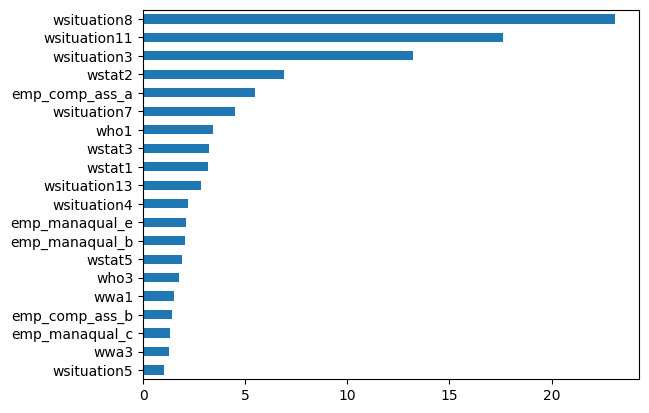

In [62]:
importance['importance_pct'].plot.barh()
plt.show()

#### Shap 변수 중요도 확인

In [63]:
# LightGBM 모델 학습된 객체: final_model
explainer = shap.TreeExplainer(final_model)

In [64]:
shap_values = explainer(X_train_res)

shap_importance = np.abs(shap_values.values).mean(axis=0)

fi_shap = pd.DataFrame({
    "feature": X_train.columns,          # 원본 feature 이름
    "importance_shap": shap_importance
}).sort_values(by="importance_shap", ascending=False).reset_index(drop=True)

print(fi_shap.head(20))

           feature  importance_shap
0      wsituation8         1.712962
1      wsituation7         1.266894
2     wsituation11         1.213341
3     wsituation13         1.167178
4           wstat2         0.998419
5             who1         0.938056
6   emp_comp_ass_a         0.666188
7      wsituation3         0.663543
8   emp_manaqual_b         0.617353
9           wstat1         0.611786
10            who3         0.558303
11  emp_manaqual_c         0.553860
12  emp_comp_ass_d         0.522273
13    satisfaction         0.507109
14    emp_winflu_c         0.489146
15     hazard_psy3         0.468624
16            who2         0.441224
17     wsituation5         0.439137
18     wsituation4         0.433978
19  emp_manaqual_e         0.416983


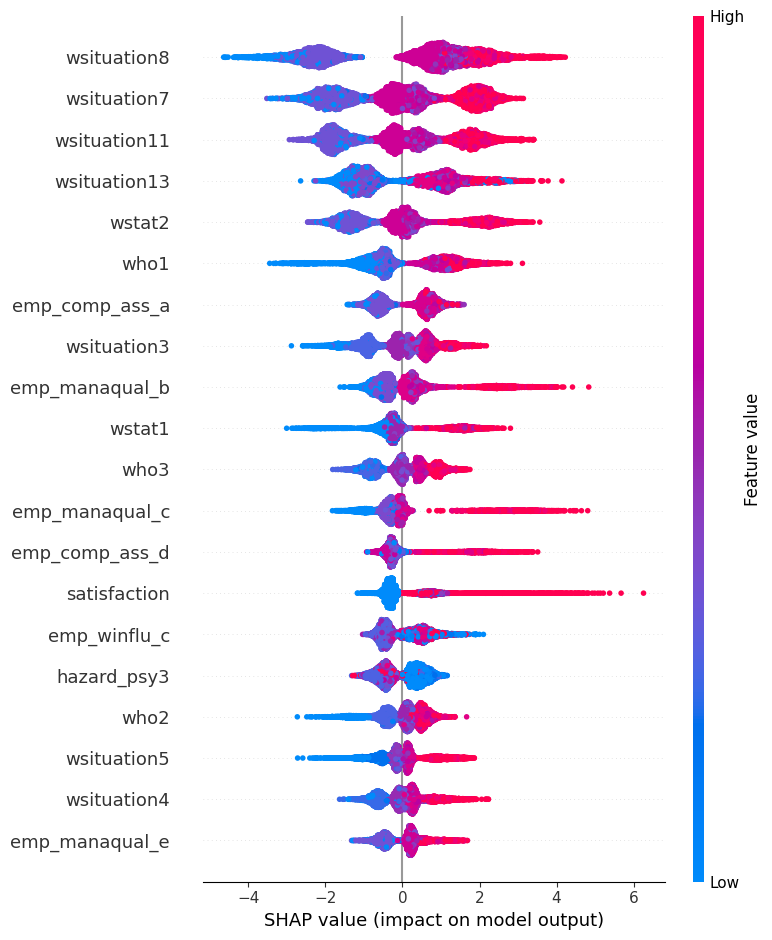

In [65]:
# summary plot

shap.summary_plot(
    shap_values,
    X_train_res,
    feature_names=X_train.columns  
)

In [66]:
shap.initjs()

X_train_res_df = pd.DataFrame(X_train_res, columns=X_train.columns)

In [84]:
# 샘플 force plot

i = 8
shap.force_plot(
    explainer.expected_value,
    shap_values.values[i, :],
    X_train_res_df.iloc[i, :]
)

In [96]:
# 샘플 force plot

i = 5
shap.force_plot(
    explainer.expected_value,
    shap_values.values[i, :],
    X_train_res_df.iloc[i, :]
)

In [97]:
# 샘플 force plot

i = 16
shap.force_plot(
    explainer.expected_value,
    shap_values.values[i, :],
    X_train_res_df.iloc[i, :]
)

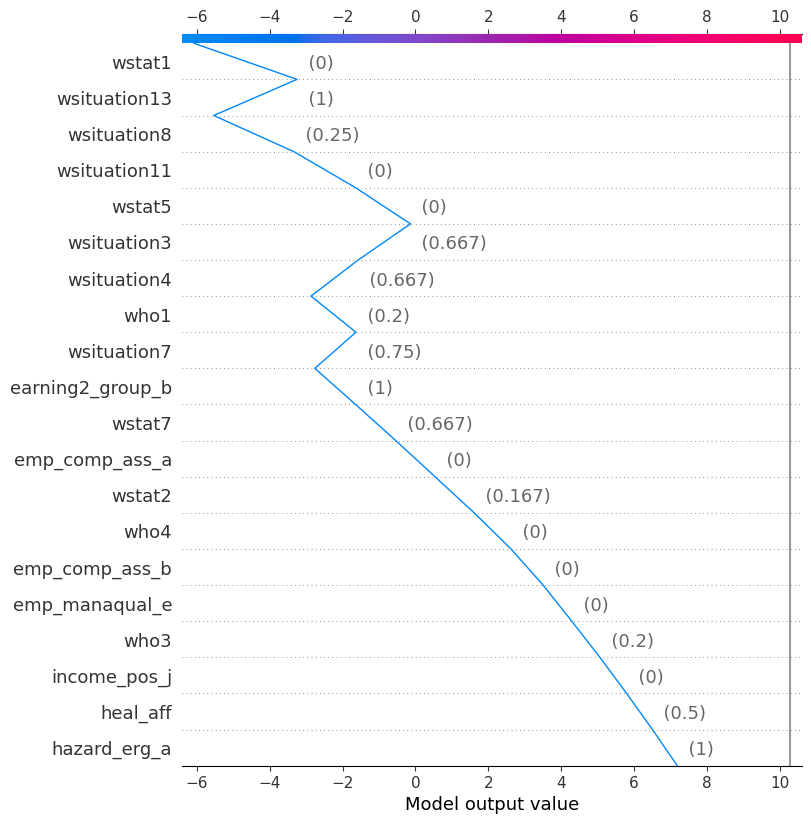

In [93]:
i = 6  # 첫 번째 샘플

shap.decision_plot(
    explainer.expected_value,
    shap_values.values[i, :],
    X_train_res_df.iloc[i, :]
)

## Feature Selection 2차

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 9075, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 9075, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start tr

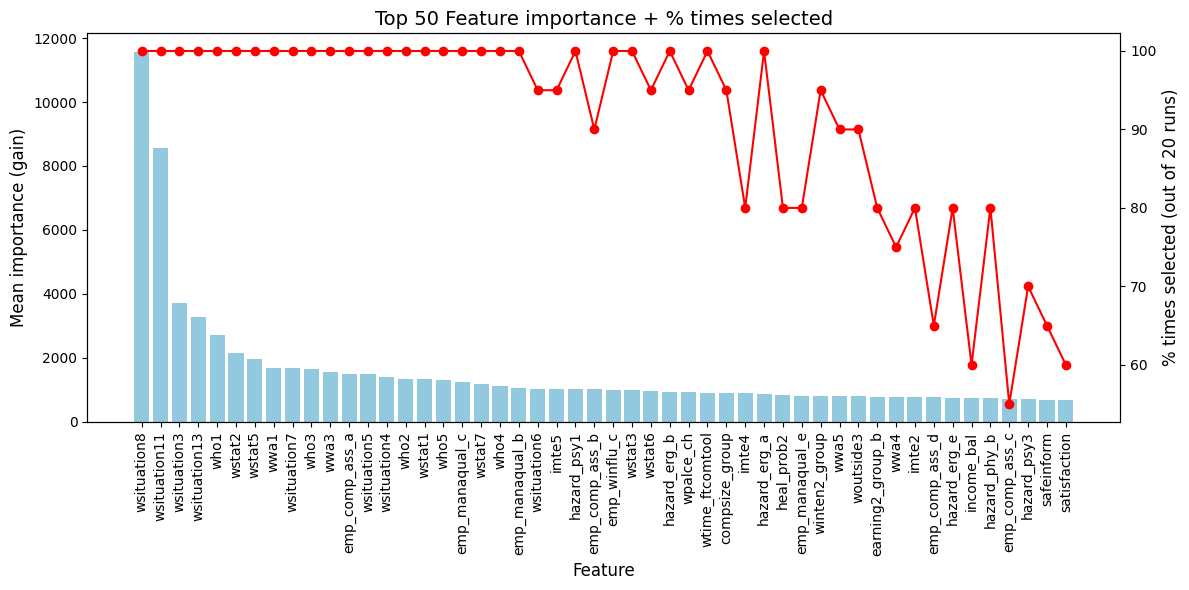

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1. 반복 학습 & 변수 선택 기록
# -------------------------
n_iter = 20          # 반복 횟수 (논문에서는 20번)
top_n = 50           # 매 반복에서 상위 N개 변수 선택
selected_counts = Counter()
importance_values = []

for i in range(n_iter):
    # 데이터 샘플링 (train/val split, 부트스트랩)
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=i
    )
    
    # 모델 학습
    model = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
        random_state=i,
        n_estimators=200
    )
    model.fit(X_tr, y_tr)
    
    # 변수 중요도 (gain 기준)
    importances = model.booster_.feature_importance(importance_type="gain")
    features = model.booster_.feature_name()
    
    # 상위 N개 선택
    top_idx = np.argsort(importances)[::-1][:top_n]
    for idx in top_idx:
        selected_counts[features[idx]] += 1
    
    # 평균 importance 계산용 저장
    importance_values.append(importances)

# -------------------------
# 2. 평균 importance와 % times selected 계산
# -------------------------
mean_importance = np.mean(importance_values, axis=0)
df_importance = pd.DataFrame({
    "feature": features,
    "importance_gain": mean_importance,
    "%_times_selected": [selected_counts[f]/n_iter*100 for f in features]
})

# 상위 20개만 정렬
df_top = df_importance.sort_values(by="importance_gain", ascending=False).head(top_n)

# -------------------------
# 3. Figure 1 스타일 시각화
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 막대그래프 (평균 gain importance)
sns.barplot(
    data=df_top,
    x="feature", y="importance_gain",
    color="skyblue", ax=ax1
)
ax1.set_ylabel("Mean importance (gain)", fontsize=12)
ax1.set_xlabel("Feature", fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# 2축 (% times selected)
ax2 = ax1.twinx()
ax2.plot(df_top["feature"], df_top["%_times_selected"], color="red", marker="o")
ax2.set_ylabel("% times selected (out of 20 runs)", fontsize=12)

plt.title(f"Top {top_n} Feature importance + % times selected", fontsize=14)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 132
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

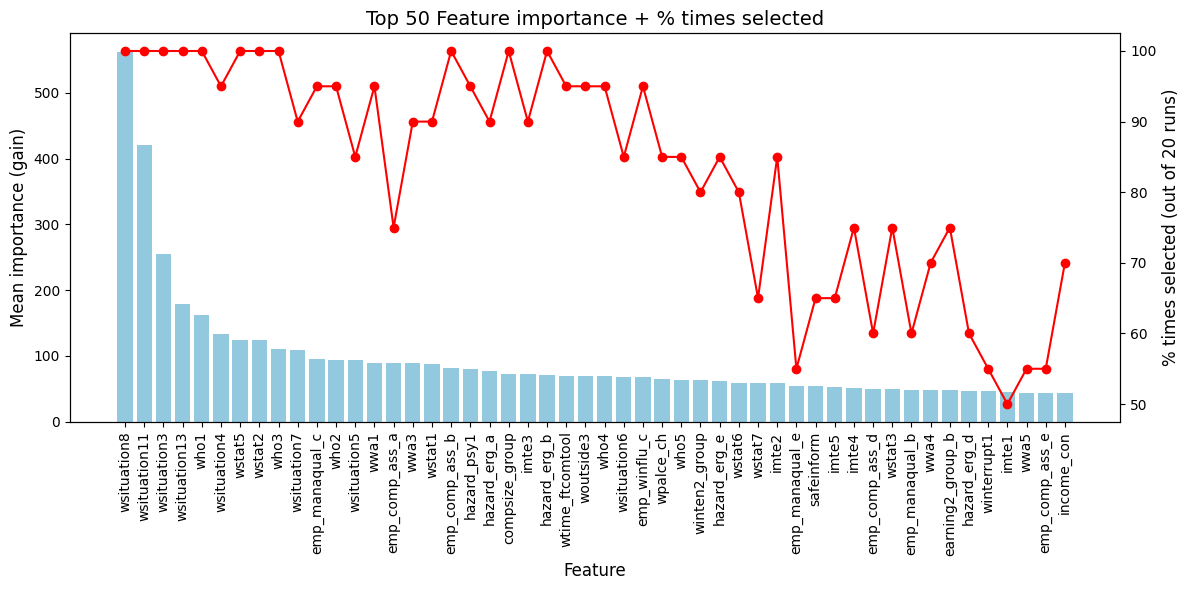

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# -------------------------
# 1. 반복 학습 & 변수 선택 기록
# -------------------------
n_iter = 20          # 반복 횟수 (논문에서는 20번)
top_n = 50           # 매 반복에서 상위 N개 변수 선택
selected_counts = Counter()
importance_values = []

for i in range(n_iter):
    # 데이터 샘플링 (train/val split, 부트스트랩)
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=i
    )
    
    # 다운샘플링
    rus = RandomUnderSampler(random_state=i)
    X_tr, y_tr = rus.fit_resample(X_tr, y_tr)
    
    # 모델 학습
    model = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
        random_state=i,
        n_estimators=200
    )
    model.fit(X_tr, y_tr)
    
    # 변수 중요도 (gain 기준)
    importances = model.booster_.feature_importance(importance_type="gain")
    features = model.booster_.feature_name()
    
    # 상위 N개 선택
    top_idx = np.argsort(importances)[::-1][:top_n]
    for idx in top_idx:
        selected_counts[features[idx]] += 1
    
    # 평균 importance 계산용 저장
    importance_values.append(importances)

# -------------------------
# 2. 평균 importance와 % times selected 계산
# -------------------------
mean_importance = np.mean(importance_values, axis=0)
df_importance = pd.DataFrame({
    "feature": features,
    "importance_gain": mean_importance,
    "%_times_selected": [selected_counts[f]/n_iter*100 for f in features]
})

# 상위 20개만 정렬
df_top = df_importance.sort_values(by="importance_gain", ascending=False).head(top_n)

# -------------------------
# 3. Figure 1 스타일 시각화
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 막대그래프 (평균 gain importance)
sns.barplot(
    data=df_top,
    x="feature", y="importance_gain",
    color="skyblue", ax=ax1
)
ax1.set_ylabel("Mean importance (gain)", fontsize=12)
ax1.set_xlabel("Feature", fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# 2축 (% times selected)
ax2 = ax1.twinx()
ax2.plot(df_top["feature"], df_top["%_times_selected"], color="red", marker="o")
ax2.set_ylabel("% times selected (out of 20 runs)", fontsize=12)

plt.title(f"Top {top_n} Feature importance + % times selected", fontsize=14)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27674
[LightGBM] [Info] Number of data points in the train set: 4658, number of used features: 146
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

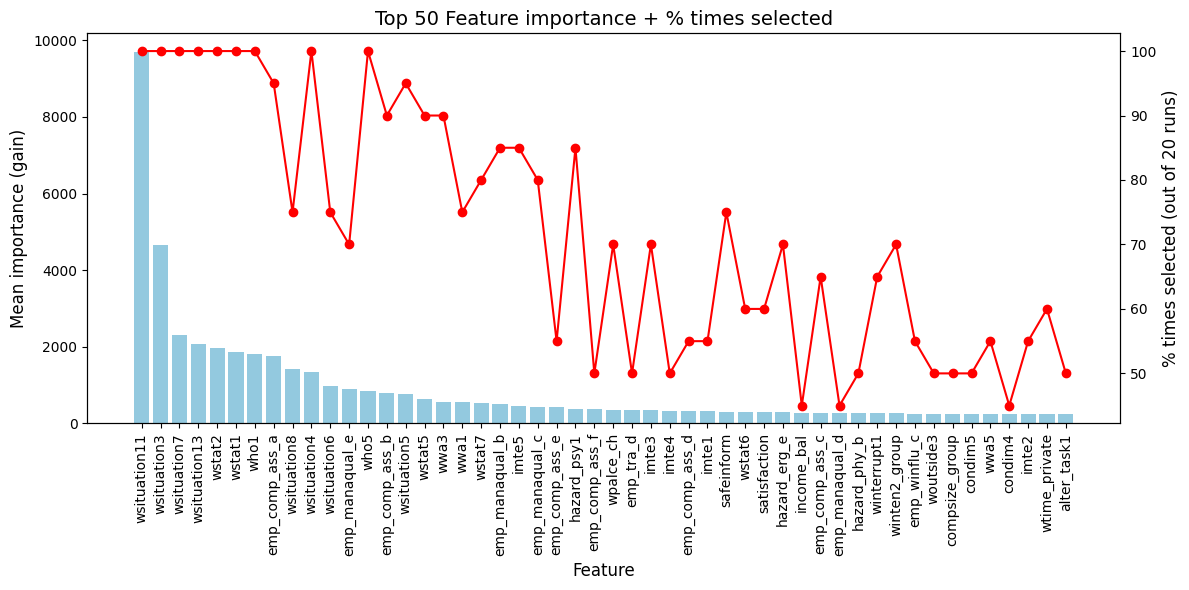

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

# -------------------------
# 1. 반복 학습 & 변수 선택 기록
# -------------------------
n_iter = 20          # 반복 횟수 (논문에서는 20번)
top_n = 50           # 매 반복에서 상위 N개 변수 선택
selected_counts = Counter()
importance_values = []

for i in range(n_iter):
    # 데이터 샘플링 (train/val split, 부트스트랩)
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_X, train_Y, test_size=0.8, stratify=train_Y, random_state=i
    )
    
    # SMOTE-ENN
    smote = SMOTE(random_state=i, k_neighbors=3)
    smote_enn = SMOTEENN(random_state=i, smote=smote)
    X_tr, y_tr = smote_enn.fit_resample(X_tr, y_tr)
    
    # 모델 학습
    model = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
        random_state=i,
        n_estimators=200
    )
    model.fit(X_tr, y_tr)
    
    # 변수 중요도 (gain 기준)
    importances = model.booster_.feature_importance(importance_type="gain")
    features = model.booster_.feature_name()
    
    # 상위 N개 선택
    top_idx = np.argsort(importances)[::-1][:top_n]
    for idx in top_idx:
        selected_counts[features[idx]] += 1
    
    # 평균 importance 계산용 저장
    importance_values.append(importances)

# -------------------------
# 2. 평균 importance와 % times selected 계산
# -------------------------
mean_importance = np.mean(importance_values, axis=0)
df_importance = pd.DataFrame({
    "feature": features,
    "importance_gain": mean_importance,
    "%_times_selected": [selected_counts[f]/n_iter*100 for f in features]
})

# 상위 20개만 정렬
df_top = df_importance.sort_values(by="importance_gain", ascending=False).head(top_n)

# -------------------------
# 3. Figure 1 스타일 시각화
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 막대그래프 (평균 gain importance)
sns.barplot(
    data=df_top,
    x="feature", y="importance_gain",
    color="skyblue", ax=ax1
)
ax1.set_ylabel("Mean importance (gain)", fontsize=12)
ax1.set_xlabel("Feature", fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# 2축 (% times selected)
ax2 = ax1.twinx()
ax2.plot(df_top["feature"], df_top["%_times_selected"], color="red", marker="o")
ax2.set_ylabel("% times selected (out of 20 runs)", fontsize=12)

plt.title(f"Top {top_n} Feature importance + % times selected", fontsize=14)
plt.tight_layout()
plt.show()

### RFECV 변수 선택 model

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# 모델 정의
final_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    class_weight="balanced",
    random_state=42,
    n_estimators=best_iter  # 최적 반복 수 적용
)

# 교차검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RFECV 실행
rfecv = RFECV(
    estimator=final_model,
    step=1,                  # 한 번에 제거할 변수 개수
    cv=cv,                   # 교차검증 방식
    scoring="roc_auc_ovr",   # 다중분류 AUC (One-vs-Rest)
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

print("최적 변수 개수:", rfecv.n_features_)
print("선택된 변수:", train_X.columns[rfecv.support_])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 6806, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 6806, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start tr

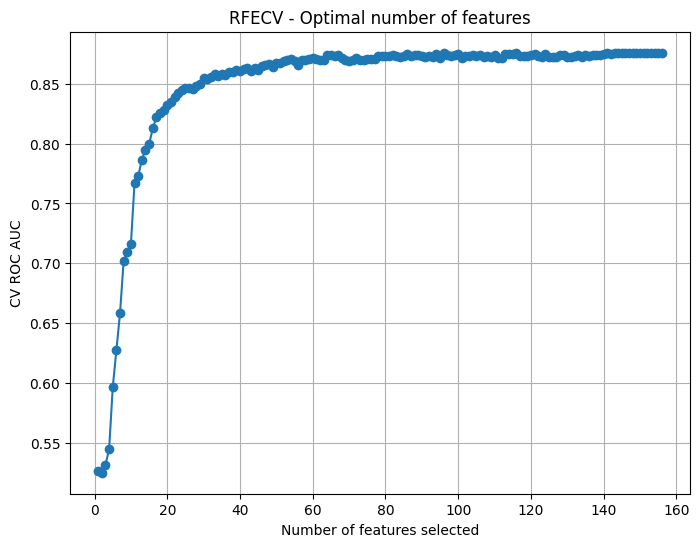

In [ ]:
# 성능 그래프 (최적 변수 개수 vs CV score)
plt.figure(figsize=(8,6))

# grid_scores_ 대신 cv_results_ 사용
mean_test_scores = rfecv.cv_results_['mean_test_score']

plt.plot(range(1, len(mean_test_scores) + 1), mean_test_scores, marker='o')
plt.xlabel("Number of features selected")
plt.ylabel("CV ROC AUC")
plt.title("RFECV - Optimal number of features")
plt.grid(True)
plt.show()

In [ ]:
# # RFECV에서 선택된 변수
# optimal_features = train_X.columns[rfecv.support_]

# # X_train에서 선택된 변수만 저장
# X_train_selected = train_X[optimal_features]